## Prototype of the bundling interface

We start by importing the `BundleCoordinator` class, which will allow to assign the atomic maps to different bundles.

In [1]:
import sys
sys.path.insert(1, "../../pipeline/bundling")
from coordinator import BundleCoordinator

We then specify the path to the atomic maps database, input for the bundling.

In [2]:
atomic_db = "/pscratch/sd/r/rosenber/so_pwg/hp_mapmaker/satp1_241031/atomic_maps_satp1_241031.db"

Time to create bundles ! We will do it for `n_bundles = 2`, a fixed seed and tell the `BundleCoordinator` to also assign maps to `high` and `low` splits for the properties listed in `null_props`.

In [3]:
bundles = BundleCoordinator(atomic_db, n_bundles=2, seed=1234, null_props=["pwv", "elevation"])

Once done, we can access to the median that was computed for the property `pwv`

In [4]:
bundles.null_props_stats["pwv"]

0.5241970370340542

We then save the database to disk, so that we can release it with the bundled maps.

In [5]:
bundles.save_db("bundles.db")

Now, if we need to get info about bundles in a separate script, we can load it from file by calling the following method. Note that you can only load part of the database by specifying the variables `bundle_id` and `null_prop_val` (which could be `high_pwv` for example)

In [6]:
bundle_load = BundleCoordinator.from_dbfile(
    "bundles.db",
    bundle_id=0,
    null_prop_val=None
)

We now have all the ingredients to actually coadd the atomic maps. Before this, we never had to open any atomic map file to generate the database. For this, we import a new class : `Bundler`.

In [7]:
from coadder import Bundler

This class needs the paths to the atomic database and bundling database. There, `obs_id` is not enough to load map files, we will add further informations about the frequency and the wafer to use. Note that setting the `wafer` argument to `None` will just load and coadd all of them.
Once the bundler object instantiated, one can run the `bundle` method to coadd maps. For this you will have to specify which bundle you want to output, as well as which null property (if `None` it will just produce the science bundle)

In [8]:
bundler = Bundler(atomic_db, "bundles.db", freq_channel="f150", wafer=None)
map, hits = bundler.bundle(bundle_id=0, null_prop_val="low_pwv")

Now we can visualize the map with `healpy`.

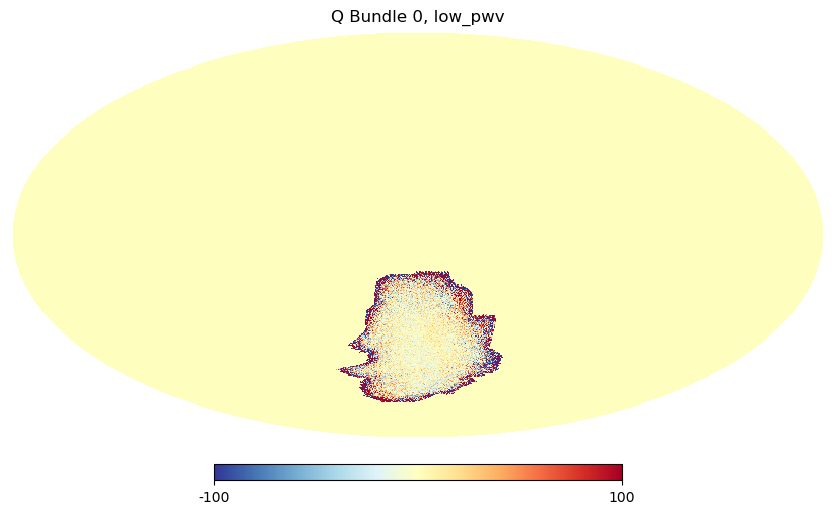

In [9]:
import healpy as hp
hp.mollview(map[1]*1e6, cmap="RdYlBu_r", title="Q Bundle 0, low_pwv", min=-100, max=100)

To generate noise simulation, one can import and instantiate an object of the `SignFlipper` class. Since we might want to generate multiple sign-flip noise realizations, we instantiate the object specifying also `bundle_id` and the null property value `null_prop_val`.

In [10]:
from coadder import SignFlipper
signflipper = SignFlipper(atomic_db, "bundles.db", freq_channel="f150", wafer=None, bundle_id=0, null_prop_val=None)

In [11]:
noise = signflipper.signflip(seed=1234)
noise2 = signflipper.signflip(seed=1235)
noise3 = signflipper.signflip(seed=1236)

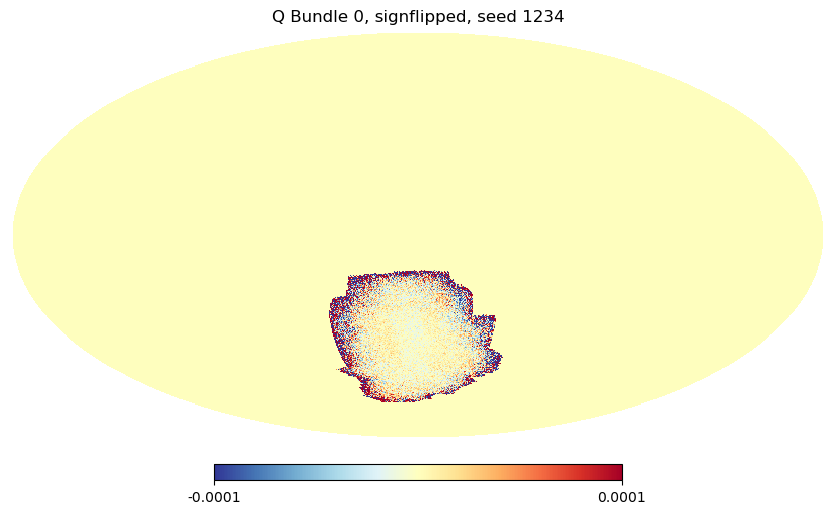

<Figure size 640x480 with 0 Axes>

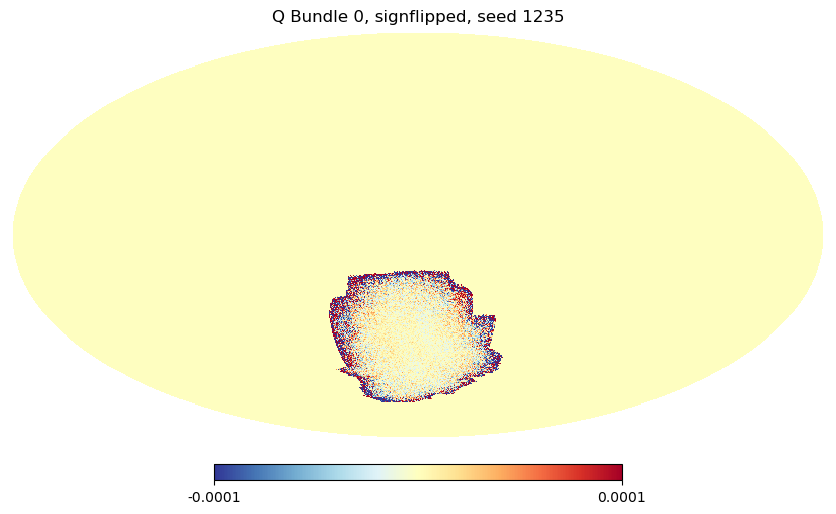

<Figure size 640x480 with 0 Axes>

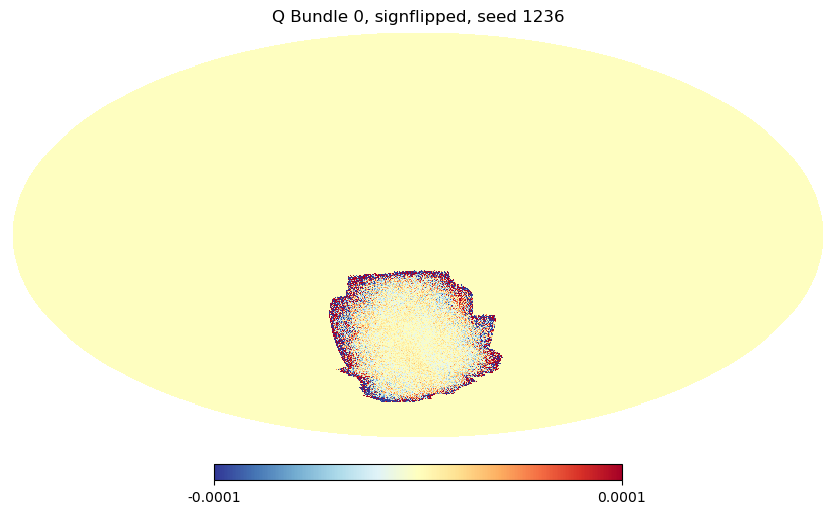

In [12]:
import healpy as hp
import matplotlib.pyplot as plt
hp.mollview(noise[1], cmap="RdYlBu_r", min=-1e-4, max=1e-4,
            title=f"Q Bundle 0, signflipped, seed 1234")
plt.figure()
hp.mollview(noise2[1], cmap="RdYlBu_r", min=-1e-4, max=1e-4,
            title=f"Q Bundle 0, signflipped, seed 1235")
plt.figure()
hp.mollview(noise3[1], cmap="RdYlBu_r", min=-1e-4, max=1e-4,
            title=f"Q Bundle 0, signflipped, seed 1236")